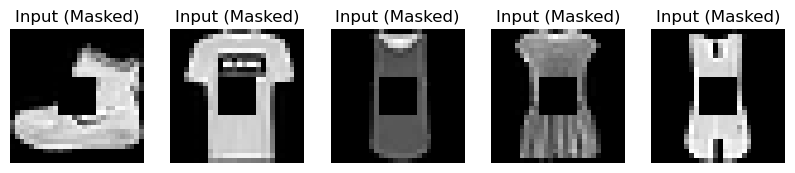

1/1 [==============================] - 1s 660ms/step


1/1 [==============================] - 0s 53ms/step
Epoch 1/10, Discriminator Loss: 0.6397726662000021, Generator Loss: 1.0300108570098876
1/1 [==============================] - 0s 62ms/step
Epoch 2/10, Discriminator Loss: 0.6198573855400086, Generator Loss: 1.2614344222386678
1/1 [==============================] - 0s 63ms/step
Epoch 3/10, Discriminator Loss: 0.6093517991304398, Generator Loss: 1.3117961226145427
1/1 [==============================] - 0s 66ms/step
Epoch 4/10, Discriminator Loss: 0.6083313817977906, Generator Loss: 1.3246448646863302
1/1 [==============================] - 0s 66ms/step
Epoch 5/10, Discriminator Loss: 0.6007041673819224, Generator Loss: 1.3633850141525268
1/1 [==============================] - 0s 77ms/step
Epoch 6/10, Discriminator Loss: 0.6046007414023081, Generator Loss: 1.3621140574455262
1/1 [==============================] - 0s 71ms/step
Epoch 7/10, Discriminator Loss: 0.5927168729305268, Generator Loss: 1.4047903953552245
1/1 [======================

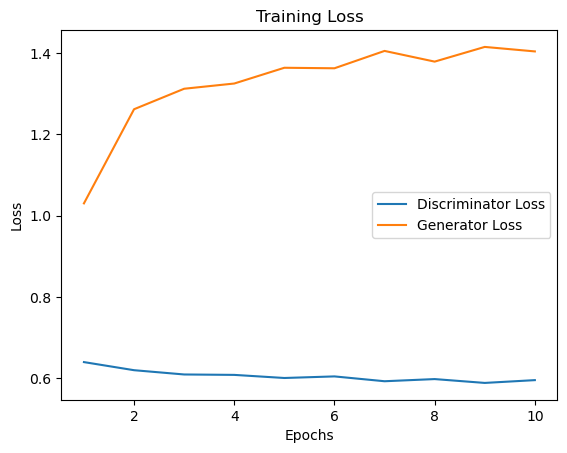

1/1 [==============================] - 0s 298ms/step


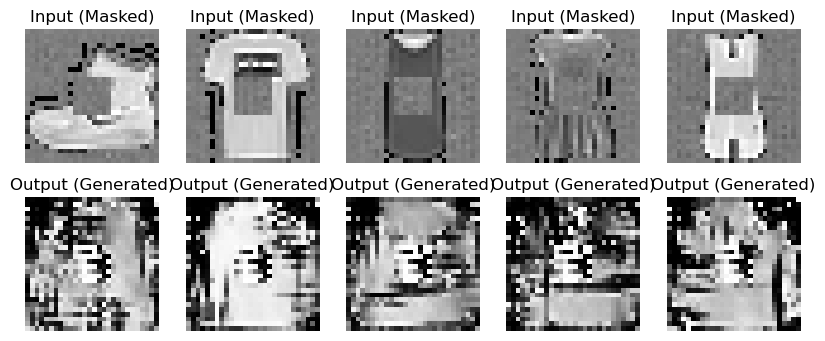

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Normalize images to range [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Add channel dimension
train_images = np.expand_dims(train_images, axis=-1)

# Mask central region in images for inpainting
mask_value = -1.0
mask_size = 8
masked_images = np.copy(train_images)

# Calculate the coordinates for the center mask
mask_x = (train_images.shape[1] - mask_size) // 2
mask_y = (train_images.shape[2] - mask_size) // 2

masked_images[:, mask_x:mask_x+mask_size, mask_y:mask_y+mask_size, :] = mask_value

# Visualize some masked images
n_samples = 5
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
plt.show()

# Generator
generator = Sequential([
    Dense(7*7*64, input_shape=(100,)),
    Reshape((7, 7, 64)),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh')
])

# Discriminator
discriminator = Sequential([
    Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)),
    LeakyReLU(alpha=0.2),
    Conv2D(64, kernel_size=3, strides=2, padding='same'),
    LeakyReLU(alpha=0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Training parameters
batch_size = 32
epochs = 10  

discriminator_losses = []
generator_losses = []

# Calculate the number of batches per epoch
num_batches_per_epoch = len(train_images) // batch_size

# Training loop
for epoch in range(epochs):
    discriminator_losses_epoch = []
    generator_losses_epoch = []

    # Shuffle the training data
    np.random.shuffle(train_images)

    for batch_idx in range(num_batches_per_epoch):
        # Sample random noise
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate images
        generated_images = generator.predict(noise)

        # Select a random batch of real images
        real_images = masked_images[batch_idx * batch_size: (batch_idx + 1) * batch_size]

        # Replace masked regions in real images with generated content
        real_images[real_images == mask_value] = generated_images[real_images == mask_value]

        # Concatenate real images with generated images
        X = np.concatenate([real_images, generated_images])

        # Labels for generated and real images
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9  # Label smoothing

        # Train discriminator
        discriminator_loss = discriminator.train_on_batch(X, y_dis)
        discriminator_losses_epoch.append(discriminator_loss[0])

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        y_gen = np.ones(batch_size)
        generator_loss = gan.train_on_batch(noise, y_gen)
        generator_losses_epoch.append(generator_loss)

    # Calculate average losses for the epoch
    discriminator_losses.append(np.mean(discriminator_losses_epoch))
    generator_losses.append(np.mean(generator_losses_epoch))

    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {discriminator_losses[-1]}, Generator Loss: {generator_losses[-1]}')

# Plot loss curves
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Generate and visualize images
n_samples = 5
noise = np.random.normal(0, 1, (n_samples, 100))
generated_images = generator.predict(noise)

plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title('Output (Generated)')
    plt.axis('off')
plt.show()
